In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = TPWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

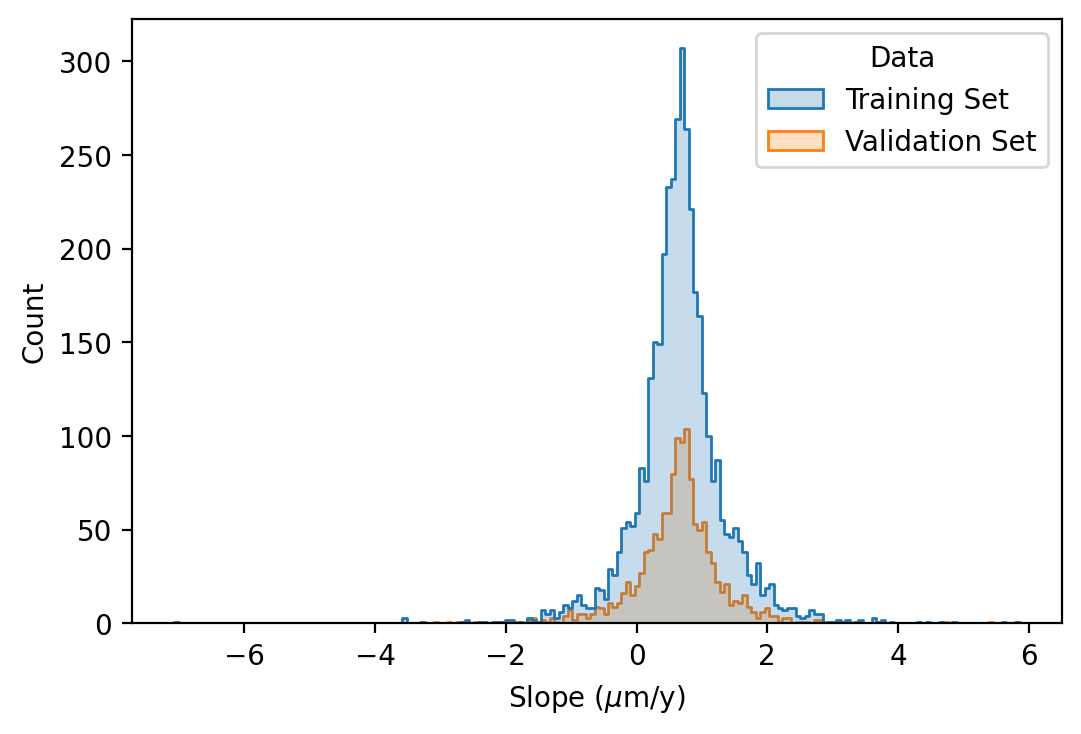

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4034 1345


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

3


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'pw_statedict.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s, batch_loss=0.0784, running_loss=34]


Train Loss: 33.9699 | Valid Loss: inf ===========> 11.6178 | Test Loss: 10.2735 | Saving model...


Epoch [2/200]: 100%|██████████| 64/64 [00:12<00:00,  5.06it/s, batch_loss=0.327, running_loss=30.2]


Train Loss: 30.1751 | Valid Loss: 11.6178 ===========> 10.3119 | Test Loss: 11.0450 | Saving model...


Epoch [3/200]: 100%|██████████| 64/64 [00:12<00:00,  5.03it/s, batch_loss=0.046, running_loss=29.8]


Train Loss: 29.7688 | Valid Loss: 13.1026


Epoch [4/200]: 100%|██████████| 64/64 [00:12<00:00,  5.07it/s, batch_loss=0.697, running_loss=30.4]


Train Loss: 30.4089 | Valid Loss: 11.8250


Epoch [5/200]: 100%|██████████| 64/64 [00:12<00:00,  5.04it/s, batch_loss=0.802, running_loss=30.3]


Train Loss: 30.2878 | Valid Loss: 10.3817


Epoch [6/200]: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s, batch_loss=0.222, running_loss=29.6]


Train Loss: 29.5748 | Valid Loss: 10.6055


Epoch [7/200]: 100%|██████████| 64/64 [00:12<00:00,  4.98it/s, batch_loss=0.106, running_loss=29.2]


Train Loss: 29.1807 | Valid Loss: 11.3154


Epoch [8/200]: 100%|██████████| 64/64 [00:12<00:00,  4.99it/s, batch_loss=0.0176, running_loss=29]


Train Loss: 28.9945 | Valid Loss: 10.3119 ===========> 9.9501 | Test Loss: 10.3526 | Saving model...


Epoch [9/200]: 100%|██████████| 64/64 [00:12<00:00,  5.05it/s, batch_loss=0.0514, running_loss=28.7]


Train Loss: 28.7352 | Valid Loss: 9.9501 ===========> 9.7262 | Test Loss: 9.7344 | Saving model...


Epoch [10/200]: 100%|██████████| 64/64 [00:12<00:00,  5.10it/s, batch_loss=0.0441, running_loss=28.6]


Train Loss: 28.6147 | Valid Loss: 9.9393


Epoch [11/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.336, running_loss=28.6]


Train Loss: 28.6135 | Valid Loss: 9.7262 ===========> 9.5347 | Test Loss: 9.6297 | Saving model...


Epoch [12/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=1.17, running_loss=29.3]


Train Loss: 29.2524 | Valid Loss: 11.3920


Epoch [13/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0936, running_loss=27.9]


Train Loss: 27.9477 | Valid Loss: 10.2055


Epoch [14/200]: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s, batch_loss=0.0848, running_loss=27.7]


Train Loss: 27.6664 | Valid Loss: 9.5347 ===========> 9.2302 | Test Loss: 9.8694 | Saving model...


Epoch [15/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.000543, running_loss=27]


Train Loss: 27.0172 | Valid Loss: 9.2302 ===========> 9.0720 | Test Loss: 9.2492 | Saving model...


Epoch [16/200]: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s, batch_loss=0.782, running_loss=27.4]


Train Loss: 27.3762 | Valid Loss: 11.2132


Epoch [17/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0179, running_loss=26.3]


Train Loss: 26.2506 | Valid Loss: 9.0720 ===========> 8.8079 | Test Loss: 8.8962 | Saving model...


Epoch [18/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0164, running_loss=25.3]


Train Loss: 25.2959 | Valid Loss: 9.8992


Epoch [19/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.101, running_loss=24.4]


Train Loss: 24.4422 | Valid Loss: 9.2843


Epoch [20/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.619, running_loss=24.1]


Train Loss: 24.0622 | Valid Loss: 14.8949


Epoch [21/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.287, running_loss=22.9]


Train Loss: 22.9075 | Valid Loss: 16.9074


Epoch [22/200]: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s, batch_loss=0.176, running_loss=22]


Train Loss: 22.0456 | Valid Loss: 14.8177


Epoch [23/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.328, running_loss=21.6]


Train Loss: 21.6187 | Valid Loss: 14.2084


Epoch [24/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.163, running_loss=19.8]


Train Loss: 19.8128 | Valid Loss: 14.9779


Epoch [25/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0832, running_loss=19.4]


Train Loss: 19.4127 | Valid Loss: 12.0830


Epoch [26/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0666, running_loss=19.4]


Train Loss: 19.3804 | Valid Loss: 8.8079 ===========> 7.9178 | Test Loss: 7.7337 | Saving model...


Epoch [27/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0281, running_loss=18]


Train Loss: 17.9931 | Valid Loss: 10.7811


Epoch [28/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0118, running_loss=18.3]


Train Loss: 18.3374 | Valid Loss: 7.9178 ===========> 6.9352 | Test Loss: 6.9894 | Saving model...


Epoch [29/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0415, running_loss=17]


Train Loss: 16.9538 | Valid Loss: 6.9352 ===========> 6.6120 | Test Loss: 8.1663 | Saving model...


Epoch [30/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.193, running_loss=16.7]


Train Loss: 16.6839 | Valid Loss: 19.2789


Epoch [31/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.382, running_loss=17.2]


Train Loss: 17.1864 | Valid Loss: 17.8365


Epoch [32/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.356, running_loss=16.6]


Train Loss: 16.5827 | Valid Loss: 9.2262


Epoch [33/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.208, running_loss=17.7]


Train Loss: 17.6520 | Valid Loss: 9.4822


Epoch [34/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.614, running_loss=15.8]


Train Loss: 15.7650 | Valid Loss: 25.5077


Epoch [35/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=3.06, running_loss=19.1]


Train Loss: 19.0593 | Valid Loss: 99.2139


Epoch [36/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0665, running_loss=18.2]


Train Loss: 18.1776 | Valid Loss: 6.6120 ===========> 6.0158 | Test Loss: 6.6683 | Saving model...


Epoch [37/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0951, running_loss=14]


Train Loss: 13.9500 | Valid Loss: 8.5220


Epoch [38/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.368, running_loss=13.5]


Train Loss: 13.4969 | Valid Loss: 7.1361


Epoch [39/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0548, running_loss=12.5]


Train Loss: 12.4707 | Valid Loss: 6.0158 ===========> 5.8324 | Test Loss: 6.1568 | Saving model...


Epoch [40/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.549, running_loss=12.9]


Train Loss: 12.9066 | Valid Loss: 16.7368


Epoch [41/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.94, running_loss=14.5]


Train Loss: 14.4857 | Valid Loss: 32.1868


Epoch [42/200]: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s, batch_loss=0.0868, running_loss=14.6]


Train Loss: 14.5629 | Valid Loss: 11.4692


Epoch [43/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.188, running_loss=12.3]


Train Loss: 12.3087 | Valid Loss: 6.7197


Epoch [44/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.237, running_loss=11.9]


Train Loss: 11.9038 | Valid Loss: 23.6568


Epoch [45/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.115, running_loss=12.4]


Train Loss: 12.4418 | Valid Loss: 8.3816


Epoch [46/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0331, running_loss=12]


Train Loss: 11.9817 | Valid Loss: 9.9975


Epoch [47/200]: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s, batch_loss=0.323, running_loss=11.6]


Train Loss: 11.5603 | Valid Loss: 11.1666


Epoch [48/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.00711, running_loss=11]


Train Loss: 10.9810 | Valid Loss: 6.5702


Epoch [49/200]: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s, batch_loss=0.217, running_loss=11.1]


Train Loss: 11.0699 | Valid Loss: 14.0858


Epoch [50/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.177, running_loss=11]


Train Loss: 10.9635 | Valid Loss: 5.8594


Epoch [51/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.491, running_loss=10.6]


Train Loss: 10.5634 | Valid Loss: 22.4822


Epoch [52/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.059, running_loss=12.2]


Train Loss: 12.1557 | Valid Loss: 7.6047


Epoch [53/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.27, running_loss=9.61]


Train Loss: 9.6113 | Valid Loss: 30.3590


Epoch [54/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0197, running_loss=9.85]


Train Loss: 9.8483 | Valid Loss: 7.1072


Epoch [55/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0694, running_loss=9.85]


Train Loss: 9.8550 | Valid Loss: 12.0907


Epoch [56/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0317, running_loss=9.03]


Train Loss: 9.0286 | Valid Loss: 7.7895


Epoch [57/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0359, running_loss=8.8]


Train Loss: 8.8023 | Valid Loss: 8.6817


Epoch [58/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.455, running_loss=9.13]


Train Loss: 9.1346 | Valid Loss: 30.9841


Epoch [59/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0382, running_loss=9.82]


Train Loss: 9.8222 | Valid Loss: 7.3790


Epoch [60/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0652, running_loss=8.82]


Train Loss: 8.8161 | Valid Loss: 5.8324 ===========> 5.4983 | Test Loss: 5.6597 | Saving model...


Epoch [61/200]: 100%|██████████| 64/64 [00:12<00:00,  5.26it/s, batch_loss=0.0735, running_loss=8.07]


Train Loss: 8.0723 | Valid Loss: 6.2540


Epoch [62/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.196, running_loss=8.11]


Train Loss: 8.1064 | Valid Loss: 7.7255


Epoch [63/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.384, running_loss=9.32]


Train Loss: 9.3165 | Valid Loss: 27.2288


Epoch [64/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.23, running_loss=8.96]


Train Loss: 8.9610 | Valid Loss: 22.1962


Epoch [65/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.142, running_loss=9.47]


Train Loss: 9.4709 | Valid Loss: 12.7723


Epoch [66/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.187, running_loss=8.37]


Train Loss: 8.3674 | Valid Loss: 6.3160


Epoch [67/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.091, running_loss=7.63]


Train Loss: 7.6309 | Valid Loss: 7.5063


Epoch [68/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.00193, running_loss=7.46]


Train Loss: 7.4604 | Valid Loss: 6.7568


Epoch [69/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0652, running_loss=7.13]


Train Loss: 7.1305 | Valid Loss: 5.7367


Epoch [70/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.1, running_loss=7.35]


Train Loss: 7.3472 | Valid Loss: 11.7529


Epoch [71/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.161, running_loss=7.69]


Train Loss: 7.6948 | Valid Loss: 6.5667


Epoch [72/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.000236, running_loss=7.18]


Train Loss: 7.1778 | Valid Loss: 5.4983 ===========> 5.2185 | Test Loss: 5.3244 | Saving model...


Epoch [73/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.328, running_loss=6.78]


Train Loss: 6.7778 | Valid Loss: 31.0163


Epoch [74/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=1.96, running_loss=9.95]


Train Loss: 9.9453 | Valid Loss: 108.6426


Epoch [75/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.124, running_loss=13.1]


Train Loss: 13.1407 | Valid Loss: 24.5113


Epoch [76/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.0983, running_loss=8.79]


Train Loss: 8.7934 | Valid Loss: 7.5075


Epoch [77/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.208, running_loss=7.43]


Train Loss: 7.4342 | Valid Loss: 8.6204


Epoch [78/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.358, running_loss=7.52]


Train Loss: 7.5190 | Valid Loss: 28.8787


Epoch [79/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.294, running_loss=8.39]


Train Loss: 8.3938 | Valid Loss: 24.6109


Epoch [80/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.00945, running_loss=8.66]


Train Loss: 8.6636 | Valid Loss: 5.2185 ===========> 5.1511 | Test Loss: 5.4599 | Saving model...


Epoch [81/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.183, running_loss=6.68]


Train Loss: 6.6757 | Valid Loss: 12.1649


Epoch [82/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0189, running_loss=6.79]


Train Loss: 6.7894 | Valid Loss: 5.1928


Epoch [83/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0827, running_loss=6.24]


Train Loss: 6.2425 | Valid Loss: 7.5863


Epoch [84/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.446, running_loss=6.91]


Train Loss: 6.9113 | Valid Loss: 17.1659


Epoch [85/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.268, running_loss=7.31]


Train Loss: 7.3090 | Valid Loss: 10.8400


Epoch [86/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.202, running_loss=7.02]


Train Loss: 7.0197 | Valid Loss: 13.1949


Epoch [87/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.231, running_loss=6.58]


Train Loss: 6.5815 | Valid Loss: 10.4465


Epoch [88/200]: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s, batch_loss=0.204, running_loss=6.75]


Train Loss: 6.7512 | Valid Loss: 13.6144


Epoch [89/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.00922, running_loss=6.46]


Train Loss: 6.4636 | Valid Loss: 5.4064


Epoch [90/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0592, running_loss=5.73]


Train Loss: 5.7322 | Valid Loss: 6.7566


Epoch [91/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0474, running_loss=5.41]


Train Loss: 5.4115 | Valid Loss: 6.0690


Epoch [92/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0497, running_loss=5.61]


Train Loss: 5.6078 | Valid Loss: 5.4994


Epoch [93/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.00193, running_loss=5.33]


Train Loss: 5.3311 | Valid Loss: 5.1817


Epoch [94/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.112, running_loss=5.42]


Train Loss: 5.4196 | Valid Loss: 11.7799


Epoch [95/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0937, running_loss=5.73]


Train Loss: 5.7322 | Valid Loss: 5.8858


Epoch [96/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.146, running_loss=5.61]


Train Loss: 5.6100 | Valid Loss: 11.0450


Epoch [97/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.257, running_loss=5.71]


Train Loss: 5.7124 | Valid Loss: 14.7359


Epoch [98/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0506, running_loss=5.78]


Train Loss: 5.7825 | Valid Loss: 6.3018


Epoch [99/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0395, running_loss=5.37]


Train Loss: 5.3727 | Valid Loss: 7.9739


Epoch [100/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0191, running_loss=4.96]


Train Loss: 4.9553 | Valid Loss: 5.1511 ===========> 4.9174 | Test Loss: 4.9459 | Saving model...


Epoch [101/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.31, running_loss=5.26]


Train Loss: 5.2593 | Valid Loss: 17.3964


Epoch [102/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.144, running_loss=5.87]


Train Loss: 5.8723 | Valid Loss: 9.3896


Epoch [103/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.266, running_loss=5.11]


Train Loss: 5.1077 | Valid Loss: 12.8352


Epoch [104/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.344, running_loss=5.96]


Train Loss: 5.9635 | Valid Loss: 35.0685


Epoch [105/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0153, running_loss=6.06]


Train Loss: 6.0646 | Valid Loss: 5.0536


Epoch [106/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.124, running_loss=4.89]


Train Loss: 4.8860 | Valid Loss: 6.8037


Epoch [107/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.061, running_loss=4.89]


Train Loss: 4.8920 | Valid Loss: 7.4259


Epoch [108/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0835, running_loss=4.85]


Train Loss: 4.8496 | Valid Loss: 9.9859


Epoch [109/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0337, running_loss=4.77]


Train Loss: 4.7747 | Valid Loss: 6.8861


Epoch [110/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0259, running_loss=4.74]


Train Loss: 4.7405 | Valid Loss: 4.9174 ===========> 4.8996 | Test Loss: 5.0852 | Saving model...


Epoch [111/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.202, running_loss=4.67]


Train Loss: 4.6720 | Valid Loss: 11.0075


Epoch [112/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0512, running_loss=5.08]


Train Loss: 5.0825 | Valid Loss: 4.9846


Epoch [113/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.754, running_loss=5.06]


Train Loss: 5.0642 | Valid Loss: 39.7766


Epoch [114/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.117, running_loss=7.45]


Train Loss: 7.4532 | Valid Loss: 9.7160


Epoch [115/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.0553, running_loss=4.94]


Train Loss: 4.9421 | Valid Loss: 9.0648


Epoch [116/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.462, running_loss=5.03]


Train Loss: 5.0259 | Valid Loss: 29.9468


Epoch [117/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.111, running_loss=5.96]


Train Loss: 5.9556 | Valid Loss: 5.6840


Epoch [118/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.297, running_loss=4.91]


Train Loss: 4.9078 | Valid Loss: 7.3888


Epoch [119/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.00759, running_loss=4.53]


Train Loss: 4.5258 | Valid Loss: 5.5039


Epoch [120/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.338, running_loss=4.67]


Train Loss: 4.6683 | Valid Loss: 13.3393


Epoch [121/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.0303, running_loss=6.84]


Train Loss: 6.8378 | Valid Loss: 4.8996 ===========> 4.8701 | Test Loss: 5.0870 | Saving model...


Epoch [122/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.158, running_loss=4.59]


Train Loss: 4.5922 | Valid Loss: 5.5270


Epoch [123/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.17, running_loss=4.31]


Train Loss: 4.3113 | Valid Loss: 4.8701 ===========> 4.8498 | Test Loss: 4.9254 | Saving model...


Epoch [124/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0922, running_loss=4.28]


Train Loss: 4.2768 | Valid Loss: 4.8498 ===========> 4.8333 | Test Loss: 5.2688 | Saving model...


Epoch [125/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.0477, running_loss=3.9]


Train Loss: 3.8963 | Valid Loss: 4.8333 ===========> 4.7847 | Test Loss: 4.9791 | Saving model...


Epoch [126/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.00387, running_loss=3.83]


Train Loss: 3.8262 | Valid Loss: 4.8061


Epoch [127/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0141, running_loss=3.79]


Train Loss: 3.7896 | Valid Loss: 4.7847 ===========> 4.7721 | Test Loss: 4.8785 | Saving model...


Epoch [128/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.186, running_loss=4]


Train Loss: 3.9999 | Valid Loss: 5.0817


Epoch [129/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=3.11, running_loss=6.96]


Train Loss: 6.9644 | Valid Loss: 5.5413


Epoch [130/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.0236, running_loss=4.07]


Train Loss: 4.0666 | Valid Loss: 4.8723


Epoch [131/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.327, running_loss=4.06]


Train Loss: 4.0568 | Valid Loss: 5.0943


Epoch [132/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.202, running_loss=3.93]


Train Loss: 3.9292 | Valid Loss: 5.1389


Epoch [133/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.358, running_loss=4.16]


Train Loss: 4.1586 | Valid Loss: 4.9579


Epoch [134/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.00568, running_loss=3.84]


Train Loss: 3.8376 | Valid Loss: 4.8563


Epoch [135/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.0942, running_loss=3.84]


Train Loss: 3.8425 | Valid Loss: 4.7721 ===========> 4.7638 | Test Loss: 4.8202 | Saving model...


Epoch [136/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.0759, running_loss=3.76]


Train Loss: 3.7591 | Valid Loss: 4.8642


Epoch [137/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0135, running_loss=3.72]


Train Loss: 3.7187 | Valid Loss: 4.8208


Epoch [138/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.0252, running_loss=3.74]


Train Loss: 3.7363 | Valid Loss: 4.7638 ===========> 4.7342 | Test Loss: 4.9618 | Saving model...


Epoch [139/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.521, running_loss=4.14]


Train Loss: 4.1431 | Valid Loss: 4.8239


Epoch [140/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.0379, running_loss=3.57]


Train Loss: 3.5706 | Valid Loss: 4.8212


Epoch [141/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0459, running_loss=3.76]


Train Loss: 3.7619 | Valid Loss: 4.8881


Epoch [142/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0246, running_loss=3.63]


Train Loss: 3.6278 | Valid Loss: 5.1118


Epoch [143/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.0235, running_loss=3.65]


Train Loss: 3.6460 | Valid Loss: 4.8499


Epoch [144/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.107, running_loss=3.7]


Train Loss: 3.7040 | Valid Loss: 4.9466


Epoch [145/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0897, running_loss=3.77]


Train Loss: 3.7723 | Valid Loss: 4.8788


Epoch [146/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.0202, running_loss=3.72]


Train Loss: 3.7159 | Valid Loss: 4.7746


Epoch [147/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0132, running_loss=3.75]


Train Loss: 3.7505 | Valid Loss: 4.8977


Epoch [148/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.155, running_loss=3.85]


Train Loss: 3.8537 | Valid Loss: 4.9044


Epoch [149/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0296, running_loss=3.65]


Train Loss: 3.6468 | Valid Loss: 5.2737


Epoch [150/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.00221, running_loss=3.49]


Train Loss: 3.4888 | Valid Loss: 4.8209


Epoch [151/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.677, running_loss=4.2]


Train Loss: 4.1995 | Valid Loss: 4.8880


Epoch [152/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.295, running_loss=3.97]


Train Loss: 3.9684 | Valid Loss: 4.9975


Epoch [153/200]: 100%|██████████| 64/64 [00:12<00:00,  5.24it/s, batch_loss=0.331, running_loss=3.87]


Train Loss: 3.8739 | Valid Loss: 5.0610


Epoch [154/200]: 100%|██████████| 64/64 [00:12<00:00,  5.26it/s, batch_loss=0.0501, running_loss=3.66]


Train Loss: 3.6614 | Valid Loss: 4.9139


Epoch [155/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.0168, running_loss=3.67]


Train Loss: 3.6738 | Valid Loss: 5.0509


Epoch [156/200]: 100%|██████████| 64/64 [00:12<00:00,  5.23it/s, batch_loss=0.053, running_loss=3.55]


Train Loss: 3.5472 | Valid Loss: 4.9382


Epoch [157/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0153, running_loss=3.62]


Train Loss: 3.6243 | Valid Loss: 4.7648


Epoch [158/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0671, running_loss=3.49]


Train Loss: 3.4888 | Valid Loss: 4.8179


Epoch [159/200]: 100%|██████████| 64/64 [00:12<00:00,  5.25it/s, batch_loss=0.0731, running_loss=3.54]


Train Loss: 3.5361 | Valid Loss: 4.9218


Epoch [160/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.0223, running_loss=3.48]


Train Loss: 3.4802 | Valid Loss: 4.7637


Epoch [161/200]: 100%|██████████| 64/64 [00:12<00:00,  5.10it/s, batch_loss=0.315, running_loss=3.74]


Train Loss: 3.7437 | Valid Loss: 5.0149


Epoch [162/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.164, running_loss=3.75]


Train Loss: 3.7516 | Valid Loss: 4.9812


Epoch [163/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.483, running_loss=3.97]


Train Loss: 3.9742 | Valid Loss: 5.0881


Epoch [164/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.0974, running_loss=3.58]


Train Loss: 3.5774 | Valid Loss: 5.1889


Epoch [165/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0169, running_loss=3.56]


Train Loss: 3.5631 | Valid Loss: 5.3819


Epoch [166/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=1.24, running_loss=4.76]


Train Loss: 4.7624 | Valid Loss: 5.7509


Epoch [167/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.00154, running_loss=3.59]


Train Loss: 3.5901 | Valid Loss: 4.8193


Epoch [168/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.00166, running_loss=3.43]


Train Loss: 3.4278 | Valid Loss: 4.8745


Epoch [169/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.00939, running_loss=3.41]


Train Loss: 3.4068 | Valid Loss: 4.9790


Epoch [170/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0276, running_loss=3.34]


Train Loss: 3.3389 | Valid Loss: 5.0570


Epoch [171/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0284, running_loss=3.44]


Train Loss: 3.4407 | Valid Loss: 4.9245


Epoch [172/200]: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s, batch_loss=0.147, running_loss=3.6]


Train Loss: 3.6033 | Valid Loss: 4.8595


Epoch [173/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.0639, running_loss=3.65]


Train Loss: 3.6461 | Valid Loss: 4.8260


Epoch [174/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0223, running_loss=3.5]


Train Loss: 3.4996 | Valid Loss: 5.0807


Epoch [175/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.169, running_loss=3.5]


Train Loss: 3.5046 | Valid Loss: 4.8309


Epoch [176/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0193, running_loss=3.35]


Train Loss: 3.3453 | Valid Loss: 4.7518


Epoch [177/200]: 100%|██████████| 64/64 [00:12<00:00,  5.32it/s, batch_loss=0.0721, running_loss=3.39]


Train Loss: 3.3889 | Valid Loss: 4.8024


Epoch [178/200]: 100%|██████████| 64/64 [00:11<00:00,  5.33it/s, batch_loss=0.0232, running_loss=3.47]


Train Loss: 3.4730 | Valid Loss: 4.8462


Epoch [179/200]: 100%|██████████| 64/64 [00:11<00:00,  5.35it/s, batch_loss=0.142, running_loss=3.62]


Train Loss: 3.6228 | Valid Loss: 4.7425


Epoch [180/200]: 100%|██████████| 64/64 [00:11<00:00,  5.34it/s, batch_loss=0.667, running_loss=4.11]


Train Loss: 4.1064 | Valid Loss: 5.2668


Epoch [181/200]: 100%|██████████| 64/64 [00:11<00:00,  5.36it/s, batch_loss=0.148, running_loss=3.65]


Train Loss: 3.6481 | Valid Loss: 4.7342 ===========> 4.7060 | Test Loss: 4.8863 | Saving model...


Epoch [182/200]: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s, batch_loss=0.291, running_loss=3.75]


Train Loss: 3.7526 | Valid Loss: 4.8232


Epoch [183/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.0201, running_loss=3.48]


Train Loss: 3.4761 | Valid Loss: 4.9740


Epoch [184/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0181, running_loss=3.45]


Train Loss: 3.4530 | Valid Loss: 4.8063


Epoch [185/200]: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s, batch_loss=0.0062, running_loss=3.46]


Train Loss: 3.4563 | Valid Loss: 4.8067


Epoch [186/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.477, running_loss=3.93]


Train Loss: 3.9294 | Valid Loss: 4.9637


Epoch [187/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0574, running_loss=3.58]


Train Loss: 3.5843 | Valid Loss: 4.9501


Epoch [188/200]: 100%|██████████| 64/64 [00:12<00:00,  5.17it/s, batch_loss=0.062, running_loss=3.41]


Train Loss: 3.4066 | Valid Loss: 4.7520


Epoch [189/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.257, running_loss=3.75]


Train Loss: 3.7466 | Valid Loss: 5.0223


Epoch [190/200]: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s, batch_loss=0.00252, running_loss=3.31]


Train Loss: 3.3105 | Valid Loss: 4.8243


Epoch [191/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.084, running_loss=3.64]


Train Loss: 3.6371 | Valid Loss: 4.9176


Epoch [192/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.27, running_loss=3.61]


Train Loss: 3.6126 | Valid Loss: 4.7259


Epoch [193/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.41, running_loss=3.82]


Train Loss: 3.8179 | Valid Loss: 5.5760


Epoch [194/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.0787, running_loss=3.53]


Train Loss: 3.5348 | Valid Loss: 5.0863


Epoch [195/200]: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s, batch_loss=0.0545, running_loss=3.47]


Train Loss: 3.4683 | Valid Loss: 5.0480


Epoch [196/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.135, running_loss=3.44]


Train Loss: 3.4373 | Valid Loss: 4.7590


Epoch [197/200]: 100%|██████████| 64/64 [00:12<00:00,  5.19it/s, batch_loss=0.159, running_loss=3.62]


Train Loss: 3.6216 | Valid Loss: 4.8688


Epoch [198/200]: 100%|██████████| 64/64 [00:12<00:00,  5.18it/s, batch_loss=0.184, running_loss=3.61]


Train Loss: 3.6071 | Valid Loss: 4.7848


Epoch [199/200]: 100%|██████████| 64/64 [00:12<00:00,  5.20it/s, batch_loss=0.31, running_loss=3.65]


Train Loss: 3.6537 | Valid Loss: 4.7065


Epoch [200/200]: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s, batch_loss=0.657, running_loss=3.87]


Train Loss: 3.8732 | Valid Loss: 4.7831


Train Loss: 3.6481 | Valid Loss: 4.7060 | Test Loss on Best Model: 4.8863


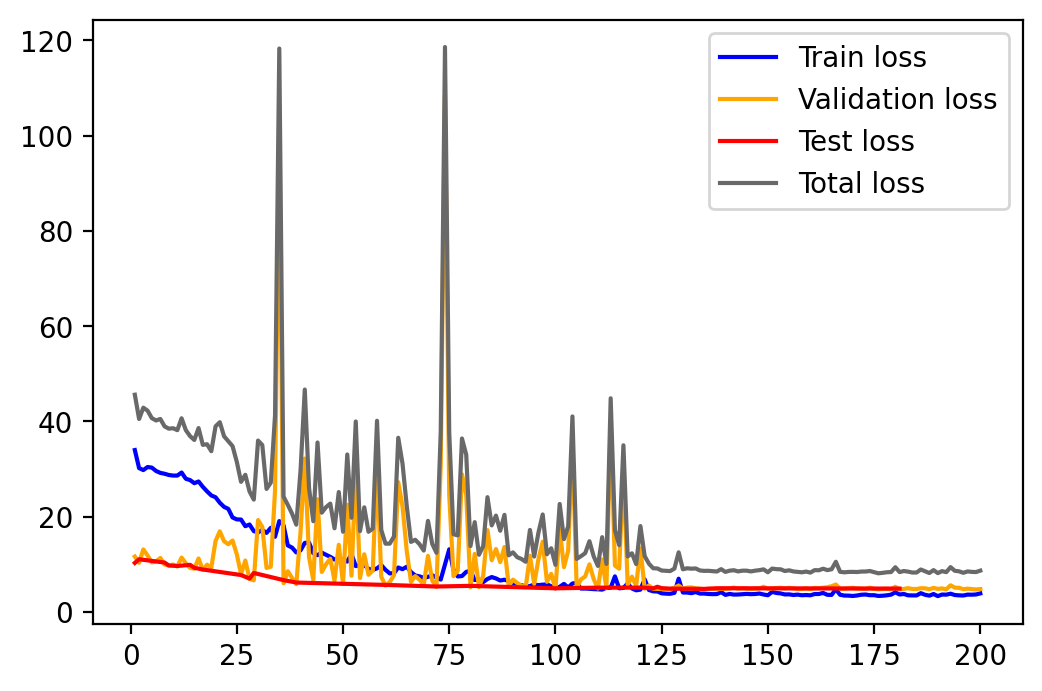

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('pw_statedict.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


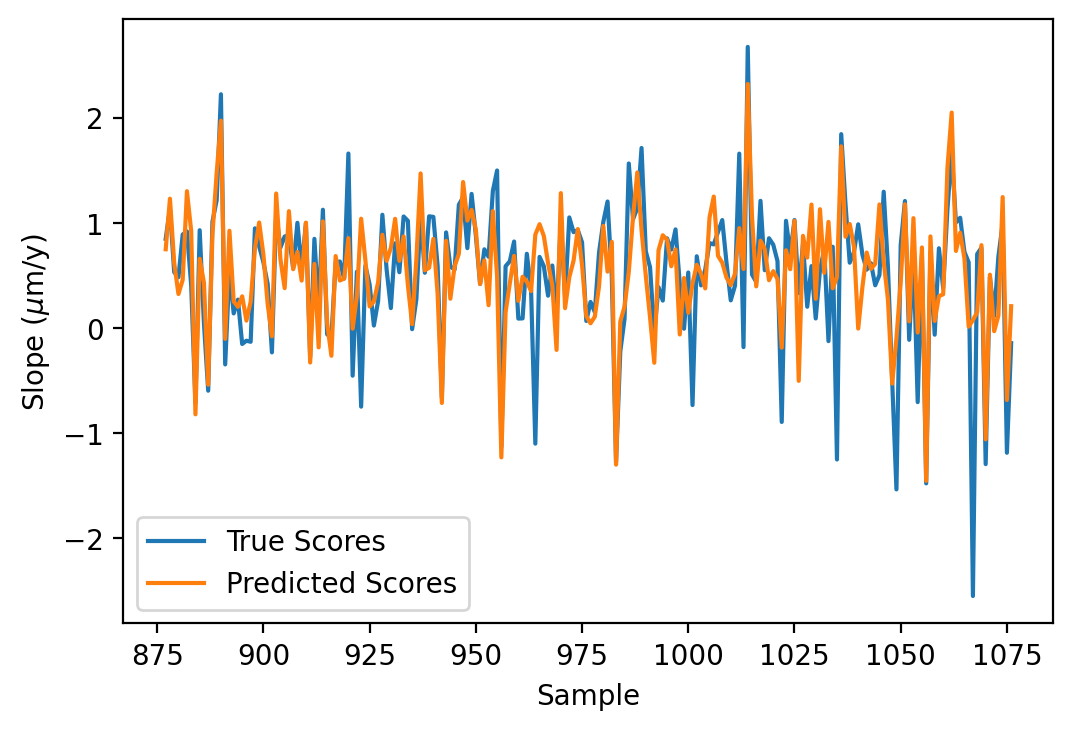

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

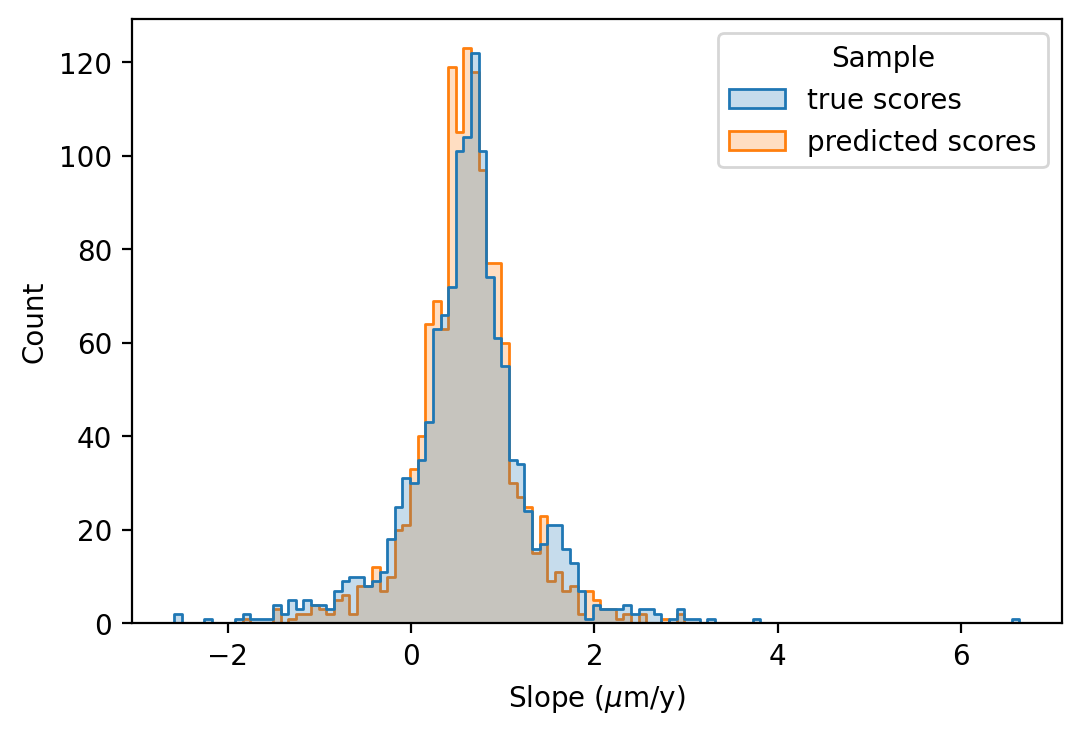

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
import pandas as pd
import numpy as np
df.to_csv('predscores.csv')
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)
print(coefficient_of_dermination)


0.5367647453642364


In [13]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [14]:
rsquared(true, pred)

0.537895389909093

In [15]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6918249394756075, pvalue=3.678364759594112e-192)

In [16]:
scipy.stats.pearsonr(true, pred)

(0.733413519038948, 2.214662696988026e-227)